In [111]:
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

## 1. Membaca Data

In [112]:
def collect_results_from_kfold(kfold_dir, target_sr=None):
    """Collect all fold results from a kfold_outputs directory
    
    Args:
        kfold_dir: Path to kfold_outputs directory
        target_sr: Target sampling rate (8000, 16000, or None for original)
    """
    results = []
    kfold_path = Path(kfold_dir)
    
    if not kfold_path.exists():
        return None
    
    # Look for multiple possible filenames
    candidate_files = [
        kfold_path / 'best_per_seed.json',
        kfold_path / 'transformer_best_per_seed.json',
        kfold_path / 'bilstm_best_per_seed.json'
    ]
    if not any(p.exists() for p in candidate_files):
        candidate_files.extend(list(kfold_path.glob('*best_per_seed.json')))
    json_file = next((p for p in candidate_files if p.exists()), None)
    
    if json_file is None:
        return None
    
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        target_sr_int = int(target_sr) if target_sr is not None else None
        if target_sr_int is not None:
            data = [item for item in data if item.get('sr') is not None and int(item.get('sr')) == target_sr_int]
        
        for item in data:
            results.append({
                'accuracy': item.get('val_acc', None),
                'seed': item.get('seed', None),
                'fold': item.get('fold', None),
                'sr': item.get('sr', None)
            })
        
        return results if results else None
    
    except Exception as e:
        print(f"Error reading {json_file}: {e}")
        return None


def collect_history_per_seed_fold(kfold_sr_dir):
    """Collect max val_acc from history.csv inside per_seed_and_fold folders.

    This is used for BiLSTM-Transformer where metrics are stored per seed/fold.
    """
    results = []
    base_path = Path(kfold_sr_dir) / 'per_seed_and_fold'
    if not base_path.exists():
        return None

    for sub in base_path.iterdir():
        if not sub.is_dir():
            continue
        history_file = sub / 'history.csv'
        if not history_file.exists():
            continue

        # Parse seed/fold/sr from folder name, e.g., bilstm_transformer_seed36_fold1_sr8000
        seed = fold = sr = None
        parts = sub.name.split('_')
        for p in parts:
            if p.startswith('seed'):
                try:
                    seed = int(p.replace('seed', ''))
                except ValueError:
                    seed = None
            if p.startswith('fold'):
                try:
                    fold = int(p.replace('fold', ''))
                except ValueError:
                    fold = None
            if p.startswith('sr'):
                try:
                    sr = int(p.replace('sr', ''))
                except ValueError:
                    sr = None

        try:
            df_hist = pd.read_csv(history_file)
            if 'val_acc' not in df_hist.columns:
                continue
            acc_max = df_hist['val_acc'].max()
            results.append({
                'accuracy': acc_max,
                'seed': seed,
                'fold': fold,
                'sr': sr
            })
        except Exception as e:
            print(f"Error reading {history_file}: {e}")
            continue

    return results if results else None


def aggregate_metrics(fold_results):
    """Aggregate accuracy mean/std and count from fold results."""
    if not fold_results:
        return None
    df = pd.DataFrame(fold_results)
    return {
        'accuracy_mean': df['accuracy'].mean(),
        'accuracy_std': df['accuracy'].std(),
        'n_folds': len(fold_results)
    }

## 2. Mengumpulkan Data dari Semua Eksperimen

In [113]:
# ===========================================================================
# 3. BiLSTM-Transformer results
# ===========================================================================
print("\n" + "="*80)
print("3. Collecting BiLSTM-Transformer results...")
print("="*80)
bilstm_transformer_count = 0

for mfcc in mfcc_counts:
    for noise_type in ['Pink', 'White']:
        for sr in ['8K', '16K']:
            # Try both with single space and double space (for 8K variants)
            if sr == '8K':
                folder_names = [
                    f'Bilstm-Transformer {sr} {noise_type} {mfcc}',
                    f'Bilstm-Transformer  {sr} {noise_type} {mfcc}'  # double space variant seen in data
                ]
                sr_value = 8000
                kfold_subdir = 'kfold_outputs_sr8000'
            else:
                folder_names = [f'Bilstm-Transformer {sr} {noise_type} {mfcc}']
                sr_value = 16000
                kfold_subdir = 'kfold_outputs_sr16000'

            folder_found = False
            for folder_name in folder_names:
                folder_path = base_dir / 'Bilstm-Transformer' / folder_name
                if folder_path.exists():
                    folder_found = True
                    kfold_dir = folder_path / kfold_subdir

                    if kfold_dir.exists():
                        # Use history.csv inside per_seed_and_fold folders because no summary JSON is present
                        fold_results = collect_history_per_seed_fold(kfold_dir)
                        if fold_results:
                            agg = aggregate_metrics(fold_results)
                            if agg:
                                results_data.append({
                                    'model': 'BiLSTM-Transformer',
                                    'noise_type': noise_type,
                                    'mfcc_coefficients': mfcc,
                                    'sampling_rate': str(sr_value),
                                    **agg
                                })
                                bilstm_transformer_count += 1
                                print(f"    ✓ {folder_name}: {len(fold_results)} folds ({sr_value} Hz)")
                        else:
                            print(f"    ✗ No history-based metrics found in {kfold_dir}")
                    else:
                        print(f"    ✗ Missing kfold dir: {kfold_dir}")
                    break  # Found the folder, no need to try other variants

            if not folder_found:
                print(f"✗ Not found: Bilstm-Transformer {sr} {noise_type} {mfcc}")

print(f"\n{'='*80}")
print(f"BiLSTM-Transformer total results collected: {bilstm_transformer_count}")
print(f"{'='*80}")

# ===========================================================================
# SUMMARY
# ===========================================================================
print("\n" + "="*80)
print("DATA COLLECTION COMPLETE")
print("="*80)
print(f"Total results collected: {len(results_data)}")
print(f"  - BiLSTM: {bilstm_count}")
print(f"  - Transformer: {transformer_count}")
print(f"  - BiLSTM-Transformer: {bilstm_transformer_count}")
print("\nNow run the next cell to create DataFrame!")


3. Collecting BiLSTM-Transformer results...
    ✓ Bilstm-Transformer 8K Pink 13: 15 folds (8000 Hz)
    ✓ Bilstm-Transformer 16K Pink 13: 15 folds (16000 Hz)
    ✓ Bilstm-Transformer 8K White 13: 15 folds (8000 Hz)
    ✓ Bilstm-Transformer 16K White 13: 15 folds (16000 Hz)
    ✓ Bilstm-Transformer 8K Pink 20: 15 folds (8000 Hz)
    ✓ Bilstm-Transformer 16K Pink 20: 15 folds (16000 Hz)
    ✓ Bilstm-Transformer 8K White 20: 15 folds (8000 Hz)
    ✓ Bilstm-Transformer 16K White 20: 15 folds (16000 Hz)
    ✓ Bilstm-Transformer 8K Pink 25: 15 folds (8000 Hz)
    ✓ Bilstm-Transformer 16K Pink 25: 15 folds (16000 Hz)
    ✓ Bilstm-Transformer 8K White 25: 15 folds (8000 Hz)
    ✓ Bilstm-Transformer 16K White 25: 15 folds (16000 Hz)
    ✓ Bilstm-Transformer 8K Pink 30: 15 folds (8000 Hz)
    ✓ Bilstm-Transformer 16K Pink 30: 15 folds (16000 Hz)
    ✓ Bilstm-Transformer 8K White 30: 15 folds (8000 Hz)
    ✓ Bilstm-Transformer 16K White 30: 15 folds (16000 Hz)
    ✓ Bilstm-Transformer 8K Pink 40

In [114]:
# Debug: Check Transformer folder
base_dir = Path(r'7-9 January Results')
transformer_dir = base_dir / 'Transformer'

print("="*80)
print("Checking Transformer folder...")
print("="*80)
print(f"Path: {transformer_dir}")
print(f"Exists: {transformer_dir.exists()}")

if transformer_dir.exists():
    folders = list(transformer_dir.iterdir())
    print(f"\nFound {len(folders)} folders:")
    for folder in sorted(folders)[:5]:
        print(f"  - {folder.name}")
        # Check kfold_outputs
        kfold = folder / 'kfold_outputs'
        if kfold.exists():
            json_file = kfold / 'best_per_seed.json'
            print(f"     kfold_outputs exists: True, best_per_seed.json: {json_file.exists()}")
            if json_file.exists():
                import json
                with open(json_file, 'r') as f:
                    data = json.load(f)
                print(f"     Data length: {len(data)}")
                if len(data) > 0:
                    print(f"     First entry SR: {data[0].get('sr', 'N/A')}")
else:
    print("\n⚠️ Transformer folder does not exist!")

Checking Transformer folder...
Path: 7-9 January Results\Transformer
Exists: True

Found 10 folders:
  - Transformer Pink 13
     kfold_outputs exists: True, best_per_seed.json: False
  - Transformer Pink 20
     kfold_outputs exists: True, best_per_seed.json: False
  - Transformer Pink 25
     kfold_outputs exists: True, best_per_seed.json: False
  - Transformer Pink 30
     kfold_outputs exists: True, best_per_seed.json: False
  - Transformer Pink 40
     kfold_outputs exists: True, best_per_seed.json: False


In [115]:
# Quick test: collect transformer sample
sample_tf_dir = Path(r'7-9 January Results/Transformer/Transformer Pink 13/kfold_outputs')
res8000 = collect_results_from_kfold(sample_tf_dir, target_sr=8000)
print(f"Transformer Pink 13 sr8000 results: {None if res8000 is None else len(res8000)} entries")
if res8000:
    print(res8000[0])

Transformer Pink 13 sr8000 results: 3 entries
{'accuracy': 0.9517082785808147, 'seed': 36, 'fold': 3, 'sr': 8000}


In [116]:
# Test path existence
print(sample_tf_dir)
print((sample_tf_dir / 'transformer_best_per_seed.json').exists())

7-9 January Results\Transformer\Transformer Pink 13\kfold_outputs
True


In [117]:
# Manual load and filter
import json
with open(sample_tf_dir / 'transformer_best_per_seed.json','r') as f:
    data = json.load(f)
print(f"Entries: {len(data)}")
print([item['sr'] for item in data])
filtered = [item for item in data if item.get('sr') == 8000]
print(f"Filtered 8000: {len(filtered)}")

Entries: 6
[8000, 8000, 8000, 16000, 16000, 16000]
Filtered 8000: 3


In [118]:
# Debug: Check folder structure and paths
import os
from pathlib import Path

print("="*80)
print("DEBUGGING: Checking folder paths")
print("="*80)

# Try different possible base paths
possible_paths = [
    Path(r'7-9 January Results'),
    Path('.') / '7-9 January Results',
    Path('..') / '7-9 January Results',
]

# Check current directory
print(f"\nCurrent working directory: {os.getcwd()}")
print(f"\nFiles and folders in current directory:")
for item in sorted(os.listdir('.')):
    if os.path.isdir(item):
        print(f"  [DIR]  {item}")
    else:
        print(f"  [FILE] {item}")

# Find the correct base path
base_dir = None
for path in possible_paths:
    print(f"\nTrying path: {path.absolute()}")
    if path.exists():
        print(f"  ✓ Path exists!")
        base_dir = path
        break
    else:
        print(f"  ✗ Path does not exist")

if base_dir is None:
    print("\n" + "!"*80)
    print("ERROR: Cannot find '7-9 January Results' folder!")
    print("!"*80)
    print("\nPlease check:")
    print("1. The folder name is correct (case sensitive)")
    print("2. The notebook is in the correct directory")
    print("3. Try running this in terminal: Get-ChildItem -Directory")
else:
    print(f"\n{'='*80}")
    print(f"FOUND BASE DIRECTORY: {base_dir.absolute()}")
    print(f"{'='*80}")
    
    # Check subdirectories
    print("\nSubdirectories in base folder:")
    for item in sorted(base_dir.iterdir()):
        if item.is_dir():
            print(f"  - {item.name}")
    
    # Check BiLSTM folders in detail
    print("\n" + "="*80)
    print("1. BiLSTM folders:")
    print("="*80)
    bilstm_path = base_dir / 'Bilstm'
    if bilstm_path.exists():
        folders = sorted([f.name for f in bilstm_path.iterdir() if f.is_dir()])
        for i, folder in enumerate(folders, 1):
            print(f"   {i}. {folder}")
            # Check what's inside
            folder_path = bilstm_path / folder
            subfolders = [f.name for f in folder_path.iterdir() if f.is_dir()]
            if subfolders:
                print(f"      Contains: {', '.join(subfolders)}")
    else:
        print("   ✗ Folder 'Bilstm' not found!")
        print(f"   Available folders: {[f.name for f in base_dir.iterdir() if f.is_dir()]}")
    
    # Check Transformer folders
    print("\n" + "="*80)
    print("2. Transformer folders:")
    print("="*80)
    transformer_path = base_dir / 'Transformer'
    if transformer_path.exists():
        folders = sorted([f.name for f in transformer_path.iterdir() if f.is_dir()])
        for i, folder in enumerate(folders, 1):
            print(f"   {i}. {folder}")
    else:
        print("   ✗ Folder 'Transformer' not found!")
    
    # Check BiLSTM-Transformer folders
    print("\n" + "="*80)
    print("3. BiLSTM-Transformer folders:")
    print("="*80)
    bilstm_transformer_path = base_dir / 'Bilstm-Transformer'
    if bilstm_transformer_path.exists():
        folders = sorted([f.name for f in bilstm_transformer_path.iterdir() if f.is_dir()])
        for i, folder in enumerate(folders, 1):
            print(f"   {i}. {folder}")
            # Check for naming patterns
            if '  ' in folder:  # double space
                print(f"      ⚠️ Note: This folder has double space!")
    else:
        print("   ✗ Folder 'Bilstm-Transformer' not found!")
    
    # Sample check for metrics.json
    print("\n" + "="*80)
    print("4. Sample check for metrics.json files:")
    print("="*80)
    if bilstm_path.exists():
        sample_folder = next(bilstm_path.iterdir(), None)
        if sample_folder:
            print(f"   Checking: {sample_folder.name}")
            kfold_dirs = ['kfold_outputs', 'kfold_outputs_sr8000', 'kfold_outputs_sr16000']
            for kfold_dir_name in kfold_dirs:
                kfold_path = sample_folder / kfold_dir_name
                if kfold_path.exists():
                    print(f"   ✓ Found: {kfold_dir_name}/")
                    fold_folders = sorted([f for f in kfold_path.glob('fold_*')])
                    if fold_folders:
                        print(f"      Contains {len(fold_folders)} fold folders")
                        first_fold = fold_folders[0]
                        metrics_file = first_fold / 'metrics.json'
                        if metrics_file.exists():
                            print(f"      ✓ metrics.json exists in {first_fold.name}")
                        else:
                            print(f"      ✗ metrics.json NOT found in {first_fold.name}")
                else:
                    print(f"   ✗ Not found: {kfold_dir_name}/")

print("\n" + "="*80)
print("DEBUG COMPLETE - Check the output above")
print("="*80)

DEBUGGING: Checking folder paths

Current working directory: c:\Users\Dricky\Downloads\Compressed\Summary v.01

Files and folders in current directory:
  [DIR]  .venv
  [DIR]  30 Koefisien
  [DIR]  7-9 January Results
  [FILE] Bab 2 Lama.md
  [FILE] Bab 3 Lama.md
  [FILE] Bab 4 Lama.md
  [FILE] Bab_2_Revisi.md
  [DIR]  Code
  [DIR]  Endless-Runner-master
  [DIR]  Experiment-Voice
  [FILE] Landasan_Teori_Kajian_Pustaka.md
  [FILE] Noise pada audio.md
  [FILE] Revisi_Bab2_Checklist.md
  [FILE] Template Menjawab Reviewer.md
  [FILE] analisis_mfcc_comparison.ipynb
  [FILE] benchmark_latency.ipynb
  [FILE] benchmark_latency.py
  [DIR]  captured_samples
  [DIR]  combined_summary_old
  [FILE] inference_log_detailed.csv
  [FILE] mfcc_accuracy_pivot.csv
  [FILE] mfcc_analysis_report.txt
  [FILE] mfcc_recommendation_scores.csv
  [FILE] mfcc_stability_analysis.csv
  [FILE] mfcc_tradeoff_analysis.csv
  [FILE] outline_teori_pustaka.md
  [FILE] test_tcp_server.py
  [DIR]  visualizations

Trying path

In [119]:
# DEBUG: Check what's inside kfold_outputs folders
from pathlib import Path

base_dir = Path(r'7-9 January Results')

# Check one sample folder in detail
sample_folder = base_dir / 'Bilstm' / 'Bilstm Pink 13'
print("="*80)
print(f"Checking sample folder: {sample_folder.name}")
print("="*80)

kfold_dir = sample_folder / 'kfold_outputs'
print(f"\nPath: {kfold_dir}")
print(f"Exists: {kfold_dir.exists()}")

if kfold_dir.exists():
    print(f"\nContents of {kfold_dir.name}:")
    items = list(kfold_dir.iterdir())
    print(f"Total items: {len(items)}")
    
    for item in sorted(items)[:10]:  # Show first 10
        if item.is_dir():
            print(f"  [DIR]  {item.name}")
            # Check what's inside this directory
            sub_items = list(item.iterdir())
            print(f"         Contains {len(sub_items)} items:")
            for sub in sorted(sub_items)[:5]:  # Show first 5
                print(f"           - {sub.name}")
        else:
            print(f"  [FILE] {item.name}")
    
    # Specifically look for fold_* directories
    print(f"\n\nSearching for fold_* directories...")
    fold_dirs = list(kfold_dir.glob('fold_*'))
    print(f"Found {len(fold_dirs)} fold directories")
    
    if fold_dirs:
        # Check first fold
        first_fold = fold_dirs[0]
        print(f"\nChecking {first_fold.name}:")
        fold_contents = list(first_fold.iterdir())
        for item in sorted(fold_contents):
            print(f"  - {item.name}")
            
        # Check if metrics.json exists
        metrics_file = first_fold / 'metrics.json'
        print(f"\nmetrics.json exists: {metrics_file.exists()}")
        
        if metrics_file.exists():
            # Try to read it
            import json
            with open(metrics_file, 'r') as f:
                data = json.load(f)
            print(f"\nmetrics.json content keys: {list(data.keys())}")
            print(f"Sample data:")
            for key, value in list(data.items())[:5]:
                print(f"  {key}: {value}")
else:
    print(f"\n⚠️ kfold_outputs folder does not exist!")

Checking sample folder: Bilstm Pink 13

Path: 7-9 January Results\Bilstm\Bilstm Pink 13\kfold_outputs
Exists: True

Contents of kfold_outputs:
Total items: 5
  [FILE] best_per_seed.csv
  [FILE] best_per_seed.json
  [FILE] best_seed36_fold4.json
  [FILE] best_seed38_fold2.json
  [FILE] best_seed42_fold2.json


Searching for fold_* directories...
Found 0 fold directories


In [120]:
# Check JSON file structure
import json
from pathlib import Path

base_dir = Path(r'7-9 January Results')
sample_folder = base_dir / 'Bilstm' / 'Bilstm Pink 13' / 'kfold_outputs'

# Read best_per_seed.json
json_file = sample_folder / 'best_per_seed.json'
print("="*80)
print(f"Reading: {json_file.name}")
print("="*80)

with open(json_file, 'r') as f:
    data = json.load(f)

print(f"\nType: {type(data)}")
if isinstance(data, dict):
    print(f"Keys: {list(data.keys())}")
    print(f"\nFull content:")
    print(json.dumps(data, indent=2))
elif isinstance(data, list):
    print(f"List length: {len(data)}")
    if len(data) > 0:
        print(f"\nFirst item:")
        print(json.dumps(data[0], indent=2))

Reading: best_per_seed.json

Type: <class 'list'>
List length: 6

First item:
{
  "seed": 36,
  "fold": 4,
  "sr": 8000,
  "val_acc": 0.9674770039421814,
  "cm_path": "/kaggle/working/kfold_outputs_sr8000/per_seed_and_fold/cm_lstm_seed36_fold4_sr8000.csv",
  "ckpt_path": "/kaggle/working/kfold_outputs_sr8000/per_seed_and_fold/lstm_seed36_fold4_sr8000/best_model.pth"
}


In [121]:
base_dir = Path(r'7-9 January Results')
results_data = []

# MFCC coefficients to analyze
mfcc_counts = [13, 20, 25, 30, 40]

# BiLSTM results
print("="*80)
print("Collecting BiLSTM results...")
print("="*80)
bilstm_count = 0
for mfcc in mfcc_counts:
    for noise_type in ['Pink', 'White']:
        folder_name = f'Bilstm {noise_type} {mfcc}'
        folder_path = base_dir / 'Bilstm' / folder_name
        
        print(f"\nChecking: {folder_name}")
        print(f"  Path exists: {folder_path.exists()}")
        
        if folder_path.exists():
            # Check kfold_outputs (original SR)
            kfold_dir = folder_path / 'kfold_outputs'
            print(f"  kfold_outputs: {kfold_dir.exists()}")
            fold_results = collect_results_from_kfold(kfold_dir, target_sr=None)
            if fold_results:
                agg = aggregate_metrics(fold_results)
                if agg:
                    results_data.append({
                        'model': 'BiLSTM',
                        'noise_type': noise_type,
                        'mfcc_coefficients': mfcc,
                        'sampling_rate': 'original',
                        **agg
                    })
                    bilstm_count += 1
                    print(f"    ✓ Collected {len(fold_results)} folds (original)")
            
            # Check kfold_outputs_sr8000
            kfold_dir = folder_path / 'kfold_outputs'
            print(f"  kfold_outputs_sr8000: {kfold_dir.exists()}")
            fold_results = collect_results_from_kfold(kfold_dir, target_sr=8000)
            if fold_results:
                agg = aggregate_metrics(fold_results)
                if agg:
                    results_data.append({
                        'model': 'BiLSTM',
                        'noise_type': noise_type,
                        'mfcc_coefficients': mfcc,
                        'sampling_rate': '8000',
                        **agg
                    })
                    bilstm_count += 1
                    print(f"    ✓ Collected {len(fold_results)} folds (8000 Hz)")
            
            # Check kfold_outputs_sr16000
            kfold_dir = folder_path / 'kfold_outputs'
            print(f"  kfold_outputs_sr16000: {kfold_dir.exists()}")
            fold_results = collect_results_from_kfold(kfold_dir, target_sr=16000)
            if fold_results:
                agg = aggregate_metrics(fold_results)
                if agg:
                    results_data.append({
                        'model': 'BiLSTM',
                        'noise_type': noise_type,
                        'mfcc_coefficients': mfcc,
                        'sampling_rate': '16000',
                        **agg
                    })
                    bilstm_count += 1
                    print(f"    ✓ Collected {len(fold_results)} folds (16000 Hz)")

print(f"\n{'='*80}")
print(f"BiLSTM total results collected: {bilstm_count}")
print(f"{'='*80}")


Checking: Bilstm Pink 13
  Path exists: True
  kfold_outputs: True
    ✓ Collected 6 folds (original)
  kfold_outputs_sr8000: True
    ✓ Collected 3 folds (8000 Hz)
  kfold_outputs_sr16000: True
    ✓ Collected 3 folds (16000 Hz)

Checking: Bilstm White 13
  Path exists: True
  kfold_outputs: True
    ✓ Collected 6 folds (original)
  kfold_outputs_sr8000: True
    ✓ Collected 3 folds (8000 Hz)
  kfold_outputs_sr16000: True
    ✓ Collected 3 folds (16000 Hz)

Checking: Bilstm Pink 20
  Path exists: True
  kfold_outputs: True
    ✓ Collected 6 folds (original)
  kfold_outputs_sr8000: True
    ✓ Collected 3 folds (8000 Hz)
  kfold_outputs_sr16000: True
    ✓ Collected 3 folds (16000 Hz)

Checking: Bilstm White 20
  Path exists: True
  kfold_outputs: True
    ✓ Collected 6 folds (original)
  kfold_outputs_sr8000: True
    ✓ Collected 3 folds (8000 Hz)
  kfold_outputs_sr16000: True
    ✓ Collected 3 folds (16000 Hz)

Checking: Bilstm Pink 25
  Path exists: True
  kfold_outputs: True
    ✓ 

In [122]:
# Transformer results
print("\n" + "="*80)
print("Collecting Transformer results...")
print("="*80)
transformer_count = 0
for mfcc in mfcc_counts:
    for noise_type in ['Pink', 'White']:
        folder_name = f'Transformer {noise_type} {mfcc}'
        folder_path = base_dir / 'Transformer' / folder_name
        
        print(f"\nChecking: {folder_name}")
        print(f"  Path exists: {folder_path.exists()}")
        
        if folder_path.exists():
            # Check kfold_outputs (original SR)
            kfold_dir = folder_path / 'kfold_outputs'
            print(f"  kfold_outputs: {kfold_dir.exists()}")
            fold_results = collect_results_from_kfold(kfold_dir, target_sr=None)
            if fold_results:
                agg = aggregate_metrics(fold_results)
                if agg:
                    results_data.append({
                        'model': 'Transformer',
                        'noise_type': noise_type,
                        'mfcc_coefficients': mfcc,
                        'sampling_rate': 'original',
                        **agg
                    })
                    transformer_count += 1
                    print(f"    ✓ Collected {len(fold_results)} folds (original)")
            
            # Check kfold_outputs_sr8000
            kfold_dir = folder_path / 'kfold_outputs'
            print(f"  kfold_outputs_sr8000: {kfold_dir.exists()}")
            fold_results = collect_results_from_kfold(kfold_dir, target_sr=8000)
            if fold_results:
                agg = aggregate_metrics(fold_results)
                if agg:
                    results_data.append({
                        'model': 'Transformer',
                        'noise_type': noise_type,
                        'mfcc_coefficients': mfcc,
                        'sampling_rate': '8000',
                        **agg
                    })
                    transformer_count += 1
                    print(f"    ✓ Collected {len(fold_results)} folds (8000 Hz)")
            
            # Check kfold_outputs_sr16000
            kfold_dir = folder_path / 'kfold_outputs'
            print(f"  kfold_outputs_sr16000: {kfold_dir.exists()}")
            fold_results = collect_results_from_kfold(kfold_dir, target_sr=16000)
            if fold_results:
                agg = aggregate_metrics(fold_results)
                if agg:
                    results_data.append({
                        'model': 'Transformer',
                        'noise_type': noise_type,
                        'mfcc_coefficients': mfcc,
                        'sampling_rate': '16000',
                        **agg
                    })
                    transformer_count += 1
                    print(f"    ✓ Collected {len(fold_results)} folds (16000 Hz)")

print(f"\n{'='*80}")
print(f"Transformer total results collected: {transformer_count}")
print(f"{'='*80}")



Checking: Transformer Pink 13
  Path exists: True
  kfold_outputs: True
    ✓ Collected 6 folds (original)
  kfold_outputs_sr8000: True
    ✓ Collected 3 folds (8000 Hz)
  kfold_outputs_sr16000: True
    ✓ Collected 3 folds (16000 Hz)

Checking: Transformer White 13
  Path exists: True
  kfold_outputs: True
    ✓ Collected 6 folds (original)
  kfold_outputs_sr8000: True
    ✓ Collected 3 folds (8000 Hz)
  kfold_outputs_sr16000: True
    ✓ Collected 3 folds (16000 Hz)

Checking: Transformer Pink 20
  Path exists: True
  kfold_outputs: True
    ✓ Collected 6 folds (original)
  kfold_outputs_sr8000: True
    ✓ Collected 3 folds (8000 Hz)
  kfold_outputs_sr16000: True
    ✓ Collected 3 folds (16000 Hz)

Checking: Transformer White 20
  Path exists: True
  kfold_outputs: True
    ✓ Collected 6 folds (original)
  kfold_outputs_sr8000: True
    ✓ Collected 3 folds (8000 Hz)
  kfold_outputs_sr16000: True
    ✓ Collected 3 folds (16000 Hz)

Checking: Transformer Pink 25
  Path exists: True
  

In [123]:
# BiLSTM-Transformer results
print("\n" + "="*80)
print("Collecting BiLSTM-Transformer results...")
print("="*80)
bilstm_transformer_count = 0

for mfcc in mfcc_counts:
    for noise_type in ['Pink', 'White']:
        for sr in ['8K', '16K']:
            # Try both with single space and double space (for 8K variants)
            folder_names = []
            if sr == '8K':
                folder_names = [
                    f'Bilstm-Transformer {sr} {noise_type} {mfcc}',
                    f'Bilstm-Transformer  {sr} {noise_type} {mfcc}'  # double space
                ]
                sr_value = 8000
                kfold_subdir = 'kfold_outputs_sr8000'
            else:
                folder_names = [f'Bilstm-Transformer {sr} {noise_type} {mfcc}']
                sr_value = 16000
                kfold_subdir = 'kfold_outputs_sr16000'
            
            folder_found = False
            for folder_name in folder_names:
                folder_path = base_dir / 'Bilstm-Transformer' / folder_name
                
                if folder_path.exists():
                    folder_found = True
                    kfold_dir = folder_path / kfold_subdir
                    print(f"\nChecking: {folder_name}")
                    print(f"  Path exists: True")
                    print(f"  Using: {kfold_subdir}")
                    print(f"  Exists: {kfold_dir.exists()}")
                    
                    if kfold_dir.exists():
                        fold_results = collect_history_per_seed_fold(kfold_dir)
                        if fold_results:
                            agg = aggregate_metrics(fold_results)
                            if agg:
                                results_data.append({
                                    'model': 'BiLSTM-Transformer',
                                    'noise_type': noise_type,
                                    'mfcc_coefficients': mfcc,
                                    'sampling_rate': str(sr_value),
                                    **agg
                                })
                                bilstm_transformer_count += 1
                                print(f"    ✓ Collected {len(fold_results)} folds ({sr_value} Hz)")
                        else:
                            print("    ✗ No history-based metrics found in per_seed_and_fold")
                    break  # Found the folder, no need to try other variants
            
            if not folder_found:
                print(f"\n✗ Not found: Bilstm-Transformer {sr} {noise_type} {mfcc}")

print(f"\n{'='*80}")
print(f"BiLSTM-Transformer total results collected: {bilstm_transformer_count}")
print(f"{'='*80}")



Checking: Bilstm-Transformer 8K Pink 13
  Path exists: True
  Using: kfold_outputs_sr8000
  Exists: True
    ✓ Collected 15 folds (8000 Hz)

Checking: Bilstm-Transformer 16K Pink 13
  Path exists: True
  Using: kfold_outputs_sr16000
  Exists: True
    ✓ Collected 15 folds (16000 Hz)

Checking: Bilstm-Transformer 8K White 13
  Path exists: True
  Using: kfold_outputs_sr8000
  Exists: True
    ✓ Collected 15 folds (8000 Hz)

Checking: Bilstm-Transformer 16K White 13
  Path exists: True
  Using: kfold_outputs_sr16000
  Exists: True
    ✓ Collected 15 folds (16000 Hz)

Checking: Bilstm-Transformer 8K Pink 20
  Path exists: True
  Using: kfold_outputs_sr8000
  Exists: True
    ✓ Collected 15 folds (8000 Hz)

Checking: Bilstm-Transformer 16K Pink 20
  Path exists: True
  Using: kfold_outputs_sr16000
  Exists: True
    ✓ Collected 15 folds (16000 Hz)

Checking: Bilstm-Transformer 8K White 20
  Path exists: True
  Using: kfold_outputs_sr8000
  Exists: True
    ✓ Collected 15 folds (8000 Hz)


In [124]:
# Debug: test one BiLSTM-Transformer folder manually
sample_bt_dir = base_dir / 'Bilstm-Transformer' / 'Bilstm-Transformer 8K Pink 13' / 'kfold_outputs_sr8000'
test_res = collect_history_per_seed_fold(sample_bt_dir)
print("Debug sample BT 8K Pink 13 -> entries:", None if test_res is None else len(test_res))
if test_res:
    print(test_res[0])

Debug sample BT 8K Pink 13 -> entries: 15
{'accuracy': np.float64(0.9773324572930356), 'seed': 36, 'fold': 1, 'sr': 8000}


In [125]:
# Check current results_data status
print(f"\n{'='*80}")
print(f"CURRENT STATUS OF results_data")
print(f"{'='*80}")
print(f"Total entries: {len(results_data)}")

# Count by model
from collections import Counter
model_counts = Counter([item['model'] for item in results_data])
print(f"\nBreakdown by model:")
for model, count in model_counts.items():
    print(f"  {model}: {count}")


CURRENT STATUS OF results_data
Total entries: 80

Breakdown by model:
  BiLSTM: 30
  Transformer: 30
  BiLSTM-Transformer: 20


In [126]:
# Create DataFrame
print(f"\n{'='*80}")
print("CREATING DATAFRAME")
print(f"{'='*80}")
print(f"Total data collected: {len(results_data)} rows")

if len(results_data) == 0:
    print("\n⚠️ WARNING: No data collected!")
    print("\nPossible reasons:")
    print("1. You haven't run the data collection cells above (cells 5, 6, 7)")
    print("2. The folder paths don't match the actual folder names")
    print("\nPlease run cell 4 first to check folder structure,")
    print("then run cells 5, 6, 7 to collect data.")
else:
    df_results = pd.DataFrame(results_data)
    print(f"\n✓ DataFrame created successfully!")
    print(f"\nModels: {df_results['model'].unique()}")
    print(f"MFCC coefficients: {sorted(df_results['mfcc_coefficients'].unique())}")
    print(f"Noise types: {df_results['noise_type'].unique()}")
    print(f"Sampling rates: {df_results['sampling_rate'].unique()}")
    
    # Display first few rows
    print("\nFirst 10 rows:")
    display(df_results.head(10))
    
    # Display summary by model
    print(f"\n{'='*80}")
    print("DATA BREAKDOWN BY MODEL:")
    print(f"{'='*80}")
    print(df_results.groupby('model').size())


CREATING DATAFRAME
Total data collected: 80 rows

✓ DataFrame created successfully!

Models: ['BiLSTM' 'Transformer' 'BiLSTM-Transformer']
MFCC coefficients: [np.int64(13), np.int64(20), np.int64(25), np.int64(30), np.int64(40)]
Noise types: ['Pink' 'White']
Sampling rates: ['original' '8000' '16000']

First 10 rows:


,model,noise_type,mfcc_coefficients,sampling_rate,accuracy_mean,accuracy_std,n_folds
0,BiLSTM,Pink,13,original,0.965561,0.001400,6
1,BiLSTM,Pink,13,8000,0.966272,0.001553,3
2,BiLSTM,Pink,13,16000,0.964849,0.000986,3
3,BiLSTM,White,13,original,0.964245,0.001274,6
4,BiLSTM,White,13,8000,0.963973,0.000684,3
5,BiLSTM,White,13,16000,0.964516,0.001836,3
6,BiLSTM,Pink,20,original,0.965670,0.002517,6
7,BiLSTM,Pink,20,8000,0.967696,0.000190,3
8,BiLSTM,Pink,20,16000,0.963644,0.001868,3
9,BiLSTM,White,20,original,0.963423,0.001776,6



DATA BREAKDOWN BY MODEL:
model
BiLSTM                30
BiLSTM-Transformer    20
Transformer           30
dtype: int64


## 3. Analisis Per Model - Rata-rata Akurasi untuk Setiap MFCC

In [127]:
# Calculate average accuracy across all conditions (noise, SR) for each model and MFCC count
summary_by_mfcc = df_results.groupby(['model', 'mfcc_coefficients']).agg({
    'accuracy_mean': ['mean', 'std', 'min', 'max'],
    'n_folds': 'first'
}).round(4)

print("\n=" * 80)
print("RINGKASAN: Performa Model berdasarkan Jumlah Koefisien MFCC")
print("(Rata-rata dari semua kondisi noise dan sampling rate)")
print("=" * 80)
print(summary_by_mfcc)

# Save to CSV
summary_by_mfcc.to_csv('mfcc_comparison_summary.csv')
print("\nFile saved: mfcc_comparison_summary.csv")


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
RINGKASAN: Performa Model berdasarkan Jumlah Koefisien MFCC
(Rata-rata dari semua kondisi noise dan sampling rate)
                                     accuracy_mean                          \
                                              mean     std     min     max   
model              mfcc_coefficients                                         
BiLSTM             13                       0.9649  0.0009  0.9640  0.9663   
                   20                       0.9645  0.0018  0.9628  0.9677   
                   25                       0.9653  0.0019  0.9634  0.9684   
                   30                       0.9639  0.0020  0.9605  0.9658   
                   40                       0.9653  0.0017  0.9627  0.9675   
BiLSTM-Transformer 13                       0.9765  0.0005  0.9758  0.9768   
                   20 

## 4. Tabel Perbandingan Akurasi (Pivot Format)

In [128]:
# Create pivot table for accuracy
accuracy_pivot = df_results.groupby(['model', 'mfcc_coefficients'])['accuracy_mean'].mean().unstack(fill_value=0)
accuracy_pivot = accuracy_pivot.round(4)

print("\n" + "=" * 80)
print("TABEL 1: Rata-rata Akurasi per Model dan Jumlah Koefisien MFCC")
print("=" * 80)
print(accuracy_pivot)

# Calculate average across all models
avg_across_models = accuracy_pivot.mean(axis=0)
print("\nRata-rata akurasi across all models:")
print(avg_across_models.round(4))

# Find best MFCC for each model
print("\nMFCC terbaik per model:")
for model in accuracy_pivot.index:
    best_mfcc = accuracy_pivot.loc[model].idxmax()
    best_acc = accuracy_pivot.loc[model, best_mfcc]
    print(f"{model}: {best_mfcc} koefisien (accuracy = {best_acc:.4f})")

# Save
accuracy_pivot.to_csv('mfcc_accuracy_pivot.csv')


TABEL 1: Rata-rata Akurasi per Model dan Jumlah Koefisien MFCC
mfcc_coefficients       13      20      25      30      40
model                                                     
BiLSTM              0.9649  0.9645  0.9653  0.9639  0.9653
BiLSTM-Transformer  0.9765  0.9761  0.9757  0.9764  0.9757
Transformer         0.9533  0.9549  0.9554  0.9540  0.9555

Rata-rata akurasi across all models:
mfcc_coefficients
13    0.9649
20    0.9652
25    0.9655
30    0.9648
40    0.9655
dtype: float64

MFCC terbaik per model:
BiLSTM: 25 koefisien (accuracy = 0.9653)
BiLSTM-Transformer: 13 koefisien (accuracy = 0.9765)
Transformer: 40 koefisien (accuracy = 0.9555)


## 5. Analisis Stabilitas dan Konsistensi

In [129]:
# Calculate coefficient of variation (CV) = std/mean for each MFCC count
stability_analysis = []

for mfcc in mfcc_counts:
    subset = df_results[df_results['mfcc_coefficients'] == mfcc]
    
    for model in ['BiLSTM', 'Transformer', 'BiLSTM-Transformer']:
        model_data = subset[subset['model'] == model]
        
        if len(model_data) > 0:
            acc_mean = model_data['accuracy_mean'].mean()
            acc_std = model_data['accuracy_mean'].std()
            cv = (acc_std / acc_mean * 100) if acc_mean > 0 else 0
            
            stability_analysis.append({
                'model': model,
                'mfcc_coefficients': mfcc,
                'accuracy_mean': acc_mean,
                'accuracy_std': acc_std,
                'cv_percent': cv,
                'min_accuracy': model_data['accuracy_mean'].min(),
                'max_accuracy': model_data['accuracy_mean'].max(),
                'range': model_data['accuracy_mean'].max() - model_data['accuracy_mean'].min()
            })

df_stability = pd.DataFrame(stability_analysis)

print("\n" + "=" * 80)
print("TABEL 2: Analisis Stabilitas dan Konsistensi")
print("(CV = Coefficient of Variation, semakin rendah = semakin stabil)")
print("=" * 80)
print(df_stability.round(4))

# Find most stable configuration (skip model if no data)
print("\n--- MFCC dengan Stabilitas Terbaik per Model ---")
for model in ['BiLSTM', 'Transformer', 'BiLSTM-Transformer']:
    model_stab = df_stability[df_stability['model'] == model]
    if len(model_stab) == 0:
        print(f"{model}: (data tidak ada)")
        continue
    best_stable = model_stab.loc[model_stab['cv_percent'].idxmin()]
    print(f"{model}: {int(best_stable['mfcc_coefficients'])} koefisien (CV = {best_stable['cv_percent']:.2f}%)")

df_stability.to_csv('mfcc_stability_analysis.csv', index=False)


TABEL 2: Analisis Stabilitas dan Konsistensi
(CV = Coefficient of Variation, semakin rendah = semakin stabil)
                 model  mfcc_coefficients  accuracy_mean  accuracy_std  \
0               BiLSTM                 13         0.9649        0.0009   
1          Transformer                 13         0.9533        0.0012   
2   BiLSTM-Transformer                 13         0.9765        0.0005   
3               BiLSTM                 20         0.9645        0.0018   
4          Transformer                 20         0.9549        0.0014   
5   BiLSTM-Transformer                 20         0.9761        0.0011   
6               BiLSTM                 25         0.9653        0.0019   
7          Transformer                 25         0.9554        0.0009   
8   BiLSTM-Transformer                 25         0.9757        0.0010   
9               BiLSTM                 30         0.9639        0.0020   
10         Transformer                 30         0.9540        0.0020   
1

## 6. Analisis Trade-off: Akurasi vs Kompleksitas

In [130]:
# Analyze performance gain vs computational cost
tradeoff_analysis = []

for model in ['BiLSTM', 'Transformer', 'BiLSTM-Transformer']:
    model_data = df_stability[df_stability['model'] == model].sort_values('mfcc_coefficients')
    
    for i in range(1, len(model_data)):
        prev = model_data.iloc[i-1]
        curr = model_data.iloc[i]
        
        mfcc_increase = curr['mfcc_coefficients'] - prev['mfcc_coefficients']
        acc_gain = curr['accuracy_mean'] - prev['accuracy_mean']
        efficiency = acc_gain / mfcc_increase if mfcc_increase > 0 else 0
        
        tradeoff_analysis.append({
            'model': model,
            'from_mfcc': int(prev['mfcc_coefficients']),
            'to_mfcc': int(curr['mfcc_coefficients']),
            'mfcc_increase': int(mfcc_increase),
            'accuracy_gain': acc_gain,
            'efficiency_ratio': efficiency
        })

df_tradeoff = pd.DataFrame(tradeoff_analysis)

print("\n" + "=" * 80)
print("TABEL 3: Trade-off Akurasi vs Kompleksitas MFCC")
print("(Efficiency ratio = accuracy gain per MFCC increase)")
print("=" * 80)
print(df_tradeoff.round(6))

df_tradeoff.to_csv('mfcc_tradeoff_analysis.csv', index=False)


TABEL 3: Trade-off Akurasi vs Kompleksitas MFCC
(Efficiency ratio = accuracy gain per MFCC increase)
                 model  from_mfcc  to_mfcc  mfcc_increase  accuracy_gain  \
0               BiLSTM         13       20              7      -0.000356   
1               BiLSTM         20       25              5       0.000713   
2               BiLSTM         25       30              5      -0.001369   
3               BiLSTM         30       40             10       0.001396   
4          Transformer         13       20              7       0.001557   
5          Transformer         20       25              5       0.000551   
6          Transformer         25       30              5      -0.001397   
7          Transformer         30       40             10       0.001506   
8   BiLSTM-Transformer         13       20              7      -0.000405   
9   BiLSTM-Transformer         20       25              5      -0.000367   
10  BiLSTM-Transformer         25       30              5     

## 7. Rekomendasi MFCC

In [ ]:
# Score each MFCC configuration based on multiple criteria
recommendation_scores = []

for mfcc in mfcc_counts:
    subset = df_stability[df_stability['mfcc_coefficients'] == mfcc]
    
    avg_accuracy = subset['accuracy_mean'].mean()
    avg_stability = 100 - subset['cv_percent'].mean() 
    min_accuracy = subset['accuracy_mean'].min()
    
    # Normalize scores (0-100)
    acc_score = (avg_accuracy - df_stability['accuracy_mean'].min()) / (df_stability['accuracy_mean'].max() - df_stability['accuracy_mean'].min()) * 100
    stability_score = avg_stability
    fairness_score = (min_accuracy - df_stability['accuracy_mean'].min()) / (df_stability['accuracy_mean'].max() - df_stability['accuracy_mean'].min()) * 100
    
    # Weighted final score 
    final_score = (acc_score * 0.5) + (stability_score * 0.3) + (fairness_score * 0.2)
    
    recommendation_scores.append({
        'mfcc_coefficients': mfcc,
        'avg_accuracy': avg_accuracy,
        'avg_cv_percent': subset['cv_percent'].mean(),
        'min_accuracy': min_accuracy,
        'accuracy_score': acc_score,
        'stability_score': stability_score,
        'fairness_score': fairness_score,
        'final_score': final_score
    })

df_recommendation = pd.DataFrame(recommendation_scores).sort_values('final_score', ascending=False)

print("\n" + "=" * 80)
print("TABEL 4: Skor Rekomendasi MFCC")
print("=" * 80)
print(df_recommendation.round(4))

best_mfcc = df_recommendation.iloc[0]
print("\n" + "=" * 80)
print("REKOMENDASI FINAL")
print("=" * 80)
print(f"\nJumlah koefisien MFCC yang direkomendasikan: {int(best_mfcc['mfcc_coefficients'])}")
print(f"\nAlasan:")
print(f"  - Rata-rata akurasi: {best_mfcc['avg_accuracy']:.4f}")
print(f"  - Coefficient of Variation: {best_mfcc['avg_cv_percent']:.2f}% (stabilitas)")
print(f"  - Akurasi minimum: {best_mfcc['min_accuracy']:.4f} (fairness)")
print(f"  - Skor akhir: {best_mfcc['final_score']:.2f}/100")

df_recommendation.to_csv('mfcc_recommendation_scores.csv', index=False)


TABEL 4: Skor Rekomendasi MFCC
   mfcc_coefficients  avg_accuracy  avg_cv_percent  min_accuracy  \
4                 40        0.9655          0.1362        0.9555   
2                 25        0.9655          0.1288        0.9554   
1                 20        0.9652          0.1488        0.9549   
3                 30        0.9648          0.1625        0.9540   
0                 13        0.9649          0.0874        0.9533   

   accuracy_score  stability_score  fairness_score  final_score  
4         52.6816          99.8638          9.5668      58.2133  
2         52.4709          99.8712          9.1001      58.0168  
1         51.1795          99.8512          6.7197      56.8890  
3         49.5460          99.8375          3.0673      55.3377  
0         50.0350          99.9126          0.0000      54.9913  

REKOMENDASI FINAL

Jumlah koefisien MFCC yang direkomendasikan: 40

Alasan:
  - Rata-rata akurasi: 0.9655
  - Coefficient of Variation: 0.14% (stabilitas)
  - Aku

## 8. Visualisasi

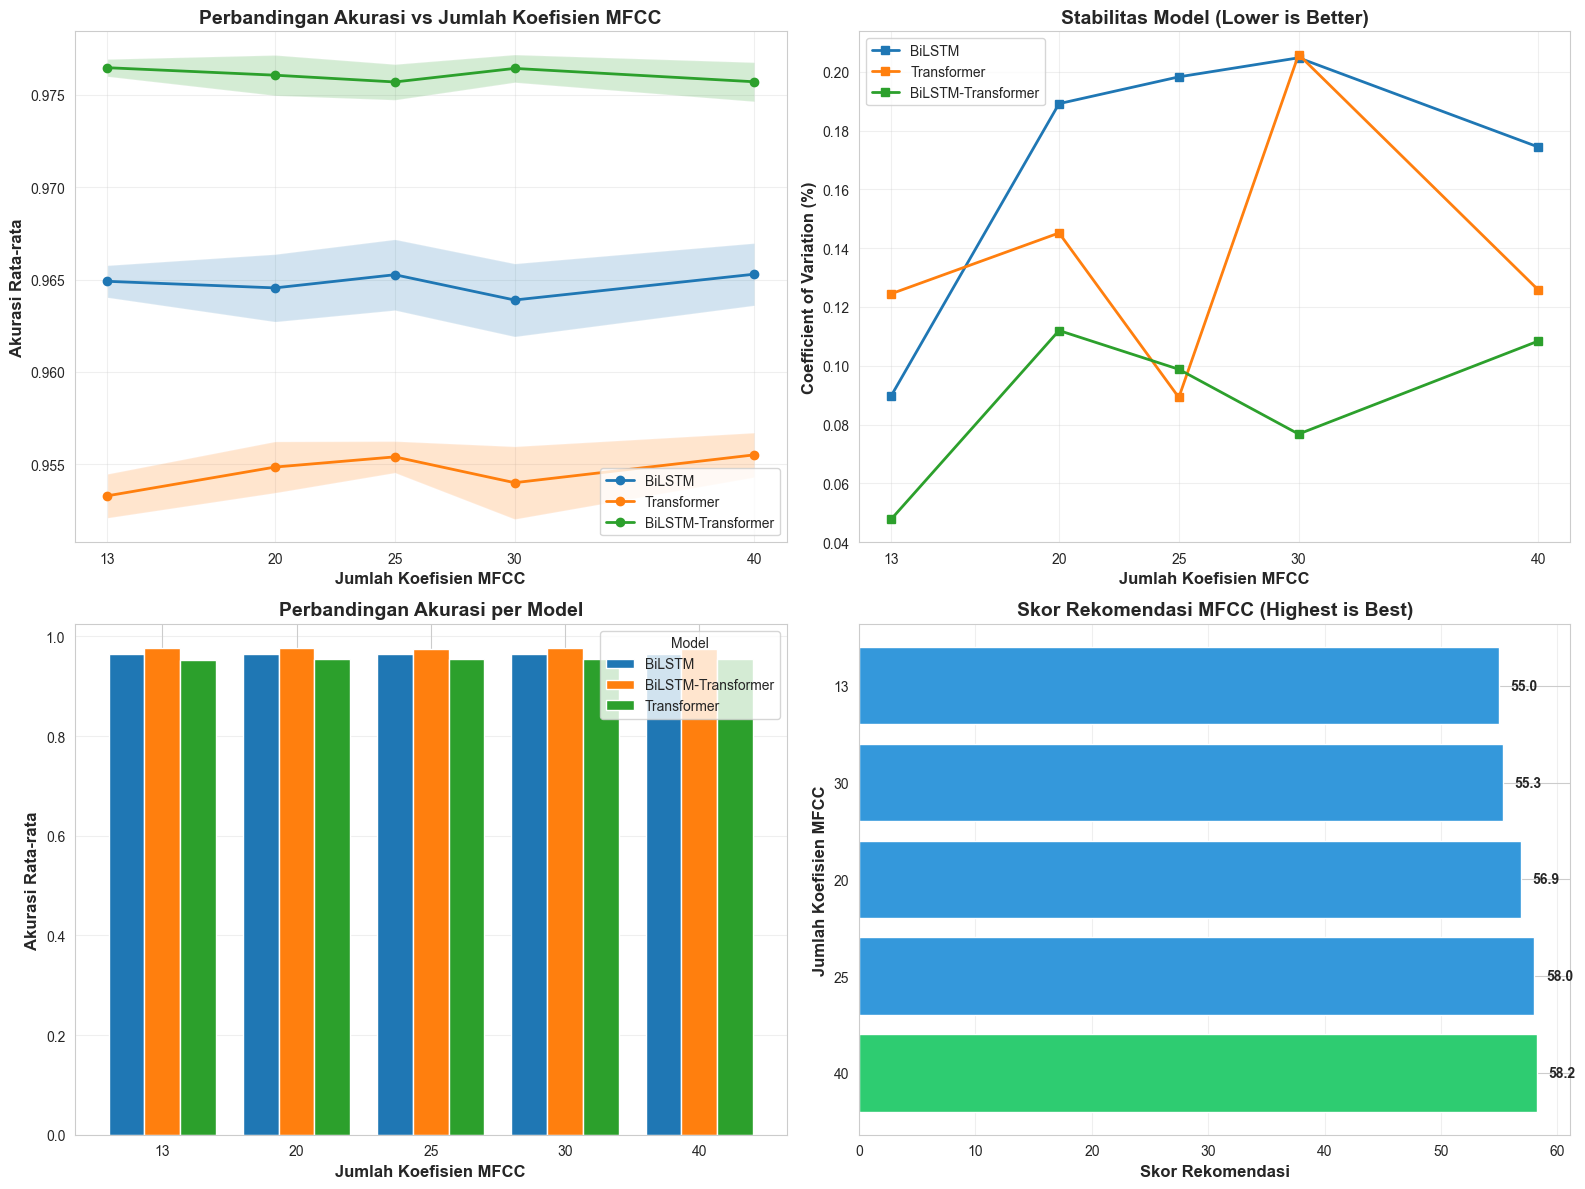


Visualisasi disimpan: mfcc_comparison_analysis.png


In [132]:
# Plot 1: Accuracy comparison across MFCC counts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Line plot of accuracy
ax = axes[0, 0]
for model in ['BiLSTM', 'Transformer', 'BiLSTM-Transformer']:
    model_data = df_stability[df_stability['model'] == model]
    ax.plot(model_data['mfcc_coefficients'], model_data['accuracy_mean'], marker='o', label=model, linewidth=2)
    ax.fill_between(model_data['mfcc_coefficients'], 
                     model_data['accuracy_mean'] - model_data['accuracy_std'],
                     model_data['accuracy_mean'] + model_data['accuracy_std'],
                     alpha=0.2)

ax.set_xlabel('Jumlah Koefisien MFCC', fontsize=12, fontweight='bold')
ax.set_ylabel('Akurasi Rata-rata', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Akurasi vs Jumlah Koefisien MFCC', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(mfcc_counts)

# Subplot 2: Stability (CV)
ax = axes[0, 1]
for model in ['BiLSTM', 'Transformer', 'BiLSTM-Transformer']:
    model_data = df_stability[df_stability['model'] == model]
    ax.plot(model_data['mfcc_coefficients'], model_data['cv_percent'], marker='s', label=model, linewidth=2)

ax.set_xlabel('Jumlah Koefisien MFCC', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
ax.set_title('Stabilitas Model (Lower is Better)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(mfcc_counts)

# Subplot 3: Bar chart of average accuracy
ax = axes[1, 0]
accuracy_pivot.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Jumlah Koefisien MFCC', fontsize=12, fontweight='bold')
ax.set_ylabel('Akurasi Rata-rata', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Akurasi per Model', fontsize=14, fontweight='bold')
ax.legend(title='Model')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Subplot 4: Recommendation scores
ax = axes[1, 1]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(df_recommendation))]
ax.barh(df_recommendation['mfcc_coefficients'].astype(str), df_recommendation['final_score'], color=colors)
ax.set_xlabel('Skor Rekomendasi', fontsize=12, fontweight='bold')
ax.set_ylabel('Jumlah Koefisien MFCC', fontsize=12, fontweight='bold')
ax.set_title('Skor Rekomendasi MFCC (Highest is Best)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add score labels
for i, (idx, row) in enumerate(df_recommendation.iterrows()):
    ax.text(row['final_score'] + 1, i, f"{row['final_score']:.1f}", va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('mfcc_comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi disimpan: mfcc_comparison_analysis.png")

## 9. Tabel Hasil

In [ ]:
# Create publication-ready table
publication_table = []

for mfcc in mfcc_counts:
    row = {'MFCC Coefficients': mfcc}
    
    for model in ['BiLSTM', 'Transformer', 'BiLSTM-Transformer']:
        model_data = df_stability[(df_stability['model'] == model) & 
                                   (df_stability['mfcc_coefficients'] == mfcc)]
        
        if len(model_data) > 0:
            mean_acc = model_data['accuracy_mean'].values[0]
            std_acc = model_data['accuracy_std'].values[0]
            row[model] = f"{mean_acc:.4f} ± {std_acc:.4f}"
        else:
            row[model] = 'N/A'
    
    publication_table.append(row)

df_publication = pd.DataFrame(publication_table)

print("\n" + "=" * 80)
print("TABEL 5: Akurasi Model dengan Berbagai MFCC")
print("=" * 80)
print(df_publication.to_string(index=False))

df_publication.to_csv('mfcc_publication_table.csv', index=False)

# LaTeX table format
print("\n" + "=" * 80)
print("FORMAT LATEX:")
print("=" * 80)
print(df_publication.to_latex(index=False))


TABEL 5: Format Publikasi - Akurasi Model dengan Berbagai MFCC
 MFCC Coefficients          BiLSTM     Transformer BiLSTM-Transformer
                13 0.9649 ± 0.0009 0.9533 ± 0.0012    0.9765 ± 0.0005
                20 0.9645 ± 0.0018 0.9549 ± 0.0014    0.9761 ± 0.0011
                25 0.9653 ± 0.0019 0.9554 ± 0.0009    0.9757 ± 0.0010
                30 0.9639 ± 0.0020 0.9540 ± 0.0020    0.9764 ± 0.0007
                40 0.9653 ± 0.0017 0.9555 ± 0.0012    0.9757 ± 0.0011

FORMAT LATEX:
\begin{tabular}{rlll}
\toprule
MFCC Coefficients & BiLSTM & Transformer & BiLSTM-Transformer \\
\midrule
13 & 0.9649 ± 0.0009 & 0.9533 ± 0.0012 & 0.9765 ± 0.0005 \\
20 & 0.9645 ± 0.0018 & 0.9549 ± 0.0014 & 0.9761 ± 0.0011 \\
25 & 0.9653 ± 0.0019 & 0.9554 ± 0.0009 & 0.9757 ± 0.0010 \\
30 & 0.9639 ± 0.0020 & 0.9540 ± 0.0020 & 0.9764 ± 0.0007 \\
40 & 0.9653 ± 0.0017 & 0.9555 ± 0.0012 & 0.9757 ± 0.0011 \\
\bottomrule
\end{tabular}

